<a href="https://colab.research.google.com/github/csgm2328/Emily/blob/master/Verify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#예측한 모델 불러와서 현재시간에서 검증하고 새로운 예측하기

In [797]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as pdr #data 받아오는 api 라이브러리
from pandas import json_normalize
import numpy as np
import plotly as py
import plotly.graph_objs as go
import requests
import os
from keras import metrics
from keras.layers import *
from keras.models import *
from keras.utils.np_utils import to_categorical
from keras.callbacks import *
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
plt.style.use('bmh')

#**Load Model**

#검증 셋팅


In [798]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [799]:
cd /content/drive/My Drive/Colab Notebooks/LSTM_models/BTC-USD/

/content/drive/My Drive/Colab Notebooks/LSTM_models/BTC-USD


In [ ]:
ls

In [801]:
# 검증할 모델을 선택하세요

from keras.models import load_model
model_name = 'BTC-UTD: [2014-07-18 ~ 2020-09-02] 128cell 64win 1bat 7000ep 0.2drop adam 0.0001lr 86400period.h5'
model = load_model(model_name)

In [802]:
!pip install jamotools

In [803]:
import jamotools #hangul_utils은 설치안되며 보다 나은 패키지
it = model_name.split(':') #이방법으로하면 모음,자음별로 삼성전자가 11자리임. 데이터프레임에서 찾으려면 4글자로 자음모음 합쳐주기
item_name = jamotools.join_jamos(it[0])

In [804]:
#1. price 개수를 검증하려는 일자에 맞춤.

train_start = model_name.split()[1].split('-')
s_y = train_start[0][1:]
s_m = train_start[1]
s_d = train_start[2]
#start_date = datetime(int(s_y), int(s_m), int(s_d))
start_date = datetime(2017,5,1)

train_end = model_name.split()[3].split('-')
year = train_end[0]
#m = train_end[1]
#d = train_end[2][:-1]
m = '10'
d = '7'

verif_gap = datetime.date(datetime.today()) - datetime.date(datetime(int(year), int(m), int(d)))
verif_gap = verif_gap.days
  

#price = price[:-verif_gap]
#real_price = real_price[:-verif_gap]

predict_day = 10
n_epoch = model_name.split(' ')[7][:-2]
window_size = int(model_name.split(' ')[5][:-3])
n_batch = int(model_name.split(' ')[6][:-3])
Title = model_name + ' [' + str(datetime.date(datetime.today())) + ' Verified]'
print(Title,verif_gap,window_size,n_batch, sep='\n')

BTC-UTD: [2014-07-18 ~ 2020-09-02] 128cell 64win 1bat 7000ep 0.2drop adam 0.0001lr 86400period.h5 [2020-11-04 Verified]
28
64
1


#Request API

In [805]:
#1405699200 2014.7.18 01:00(GMT+9)부터 24시간 주기
#milliseconds 단위로 변환시켜주는 timestamp()
#start_date = datetime(2017,5,1)
start = int(start_date.timestamp()) #꼭 tuple이었던 변수를 datetime으로 넣을 때는 *을 붙여줘야함
ret = requests.get('https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start={}&end=9999999999&period=86400'.format(start))
print(ret)

<Response [200]>


In [806]:
js = ret.json()
print(js[-1])
df = pd.DataFrame(js)

{'date': 1604448000, 'high': 14240, 'low': 13532.19398223, 'open': 14014.59395478, 'close': 14041.19853331, 'volume': 15738002.10518629, 'quoteVolume': 1134.22195507, 'weightedAverage': 13875.59289858}


In [ ]:
scaler = MinMaxScaler()
real_price = df['close'].tolist()
price = scaler.fit_transform(df[['close']]).reshape(-1).tolist()  #tolist로 만들어줌

print('오늘은',datetime.today(), real_price[-1], len(real_price), '개') # GMT +0 기준

오늘은 2020-11-04 18:14:08.047176 14041.19853331 1284 개


#make DataSet

In [812]:
x = []  #5일의 데이터를 넣고 다음날을 예측하는 방식 (특징벡터 - 훈련집합)
y = []  #5+1일의 데이터를 넣고 (결과값 - 훈련집합)

for i in range(len(price) - window_size):   #1916-5 = 1911 Range는 마지막 1910까지임
  x.append([price[i+j] for j in range(window_size)])
  y.append(price[window_size + i])

x = np.asarray(x)
y = np.asarray(y)
print(x.shape) # [1911,5] list
print(type(y)) 
#print(x[-1])  # [1911,5] list
#print(price[-1]) #[1916, 1]
#print(y[-1])  #[1911, 1]

(1220, 64)
<class 'numpy.ndarray'>


In [813]:
train_test_split = int(len(x)*0.3) #1200개에서 1357개로 증가후에 acc: 0.0017 --> 0.0015
split_pt = train_test_split + window_size

x_train = x[:train_test_split, :]
y_train = y[:train_test_split]

x_test = x[train_test_split:, :]
y_test = y[train_test_split:]

xtrain = x_train.reshape((x_train.shape[0], x_train.shape[1], 1)) # 2차원 데이터 3차원화, LSTM의 데이터 생성할때 주의해야하는 포인트, [sequence,  batch, input_dim]
xtest =  np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  #test 집합을 늘리면 미래를 예측할 수 있을까?

print(xtrain.shape)#print(x_train.shape) #계속 변함
print(x_test.shape) #계속 변함
#print(y_train[0])
#print(price[4])


(366, 64, 1)
(854, 64)


#**Prediction**

In [814]:
#train, test prediction
train_pred = model.predict(xtrain,batch_size=n_batch) # x[0~window_size-1] 만큼의 특징벡터를 학습해서 학습데이터 수 
model.reset_states()
test_pred = model.predict(xtest,batch_size=n_batch)
model.reset_states()
real_train_pred = scaler.inverse_transform(train_pred)
real_test_pred = scaler.inverse_transform(test_pred)

#(t+n)일 예측하기 

In [815]:
#(t+n)일 예측 시뮬레이션 (순수 predict)
def predict_future():
  if (verif_gap != 0):
    today = xtest[-verif_gap-1]
    today = np.vstack((today[1:], price[-verif_gap]))
    seq_in = today 
    fut = np.zeros((verif_gap+predict_day,1))

    i = 0
    for i in range(verif_gap): #과거 예측결과 평가를 위한
      sample_in = seq_in.reshape(1,window_size,1)
      after = model.predict(sample_in, batch_size=n_batch)
      model.reset_states() #없으면 예측값 계속 바뀜
      seq_in = np.vstack((seq_in[1:], after))
      fut[i] = after
    
    #검증 후 예측
    today = xtest[-1]
    today = np.vstack((today[1:], price[-1]))
    seq_in = today

    i+=1 #배열 다음위치부터
    for i in range(i,i+predict_day,1):
      sample_in = seq_in.reshape(1,window_size,1)
      after = model.predict(sample_in, batch_size=n_batch)
      model.reset_states() 
      seq_in = np.vstack((seq_in[1:], after))
      fut[i] = after

  else: #그날 바로 검증일때
    today = xtest[-1]
    today = np.vstack((today[1:], price[-1]))
    seq_in = today 
    fut = np.zeros((predict_day,1))

    for i in range(predict_day): 
      sample_in = seq_in.reshape(1,window_size,1)
      after = model.predict(sample_in, batch_size=n_batch)
      model.reset_states() 
      seq_in = np.vstack((seq_in[1:], after))
      fut[i] = after
  

  real_fut = scaler.inverse_transform(fut)
  return real_fut, fut

In [816]:
############Verify or Modify Simulation

#하루마다 갱신하는 예측 오늘치는 갱신하고 그 다음날거랑 마지막 거 새로예측
#하루늦게 추종하니까 안좋은 결과
verif_price = price
real_verif_price = real_price

today = xtest[-verif_gap]
today = np.vstack((today[1:], price[-verif_gap]))
seq_in = today #오늘꺼 까지 넣고 
verif_after_pred = np.zeros((predict_day+verif_gap,1)) #15일치
sample_in = seq_in.reshape(1,window_size,1)
after = model.predict(sample_in, batch_size=n_batch)
model.reset_states() #없으면 예측값 계속 바뀜
verif_after_pred[0] = after #첫번째꺼는 이미지났으니까 유지하고

#seq_in[window_size-predict_day-1] = verif_price[-verif_gap] # 7월 10일 기준. 11일 예측치를, 11일 actual data로 갱신
j = 1
for i in range(verif_gap, 0, -1): #
  seq_in = np.vstack((seq_in[1:], verif_price[-i])) #11일 acutual 추가
  sample_in = seq_in.reshape(1, window_size, 1)
  after = model.predict(sample_in, batch_size=n_batch) #갱신된 11일치로 12일치 다시 예측
  model.reset_states()
  #seq_in = np.vstack((seq_in[1:], after))    #12일 예측치를 after에만 추가 seq_in에는 actual만 들어가야하므로
  #verif_after_pred = np.vstack((verif_after_pred, after)) #전부다 갱신해줘야함 새로운 배열
  verif_after_pred[j] = after
  j+=1

seq_in = np.vstack((seq_in[1:], verif_after_pred[j-1])) # 17일을 위한 16일은 넣어주고
for i in range(j,predict_day+verif_gap):
  sample_in = seq_in.reshape(1, window_size, 1)
  after = model.predict(sample_in, batch_size=n_batch)
  model.reset_states()
  seq_in = np.vstack((seq_in[1:], after))
  verif_after_pred[i] = after

real_verif_after_pred = scaler.inverse_transform(verif_after_pred)

In [817]:
#학습된 모델로 (t+n)일 예측하기
#t+1 ~ t+day 예측을 위한 특징데이터 준비
today = xtest[-1] #여기엔 마지막데이터 없음
today = np.vstack((today[1: ], verif_price[-1]))
seq_in = today 
after_pred = np.zeros((predict_day,1))

for i in range(predict_day):
  sample_in = seq_in.reshape(1,window_size,1)
  after = model.predict(sample_in, batch_size=n_batch) 
  model.reset_states() #없으면 예측값 계속 바뀜
  seq_in = np.vstack((seq_in[1:], after))
  after_pred[i] = after
  
real_after_pred = scaler.inverse_transform(after_pred)

In [818]:
#MCC를 사용하는 이유
TP = 90
FN = 4
TN = 1
FP = 5
#ACC는 91%지만, MCC는 균형적이지 못해서 낮게 나온다!! 하락 5번중 한번밖에 못맞췄으므로
MCC = (TP * TN - FP * FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
FM = np.sqrt((TP/(TP+FP) * (TN/(TP+FN))))
#print('%.2f%%' %(100*(0.5 + MCC/2)))
MCC

0.13524203070138519

In [819]:
#MCC의 오류 한쪽이 1이거나 1에가까우면 과긍정평가
TP = 5
FN = 10 
TN = 5
FP = 0
(TP/(TP+FN))*0.5 + (TN/(TN+FP))*0.5

0.6666666666666666

In [820]:
#F1 score는 지나치게 긍정적으로 평가되는 경향이 있다. 분류문제인 양수인지 음수인지를 판별할 때는 MCC를 사용한다
#MCC는 -1 ~ +1 사이 값을 나타내며 0은 임의 예측과 같은성능
#방향 정확성 평가, MCC는 상승하락에 대해 균형있게 예측했는지 평가
#8/27 수많은 모델 검사결과 MCC가 ACC보다 오히려 과긍정으로 나타났다. TP*TN - FP*FN 의 한계 때문이였음
#Matthews correlation coefficient, confusion Matrix 
def MCC(actual, target, t): 
  TP, TN, FP, FN = 0,0,0,0
  ACC_List = [] 
  MCC_List = []

  for i in range(len(target)):
    if (actual[i+t] - actual[i+t-1] > 0): #상승
      if (target[i] - actual[i+t-1] > 0): #상승예측
        TP += 1
      else:
        FN += 1
    elif (actual[i+t] - actual[i+t-1] < 0): # 하락
      if (target[i] - actual[i+t-1] < 0):
        TN += 1
      else:
        FP += 1
    else: #그대로
      if (target[i] == actual[i+t-1]):
        TP += 1
      elif (target[i] - actual[i+t-1] > 0):
        FP += 1
      else:
        FN += 1
    N = TP + TN + FP + FN
    S = (TP + FN) / N
    P = (TP + FP) / N
    ACC = (TP + TN) / N
    MCC = (TP / N - S * P) / np.sqrt(P*S*(1-S)*(1-P))
    ACC_List.append(ACC)
    MCC_List.append(MCC)

  N = TP + TN + FP + FN
  S = (TP + FN) / N
  P = (TP + FP) / N
  ACC = (TP + TN) / N
  MCC = (TP / N - S * P) / np.sqrt(P*S*(1-S)*(1-P))
  #MCC = (TP * TN - FP * FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
  #두개가 0이되면 측정안됨
  print(TP,FN,TN,FP)
  #print(ACC_List)
  #print(MCC_List)
  print('방향정확도: %.3f%%\nMCC: %.2f\n' %(ACC*100,MCC))
  #return ACC_List, MCC_List

In [821]:
#keras 라이브러리 내 mape 평가는 값이 너무 큼 mae,mse 전부다
def MAPE(actual, target, t): #Mean absolute percentage error
  scores = []
  for i in range(len(target)):
    scores.append(np.abs((actual[i+t] - target[i]) / actual[i+t]))
  print('값 오차율: %.2f%%' %(np.average(scores)*100))
  #return scores

In [822]:
#함수호출
#real_after_pred, after_pred = predict_future()

In [823]:
#정규화상태로 하면 0에 가까워질때 값이 너무커지는 함정
MAPE(real_price, real_train_pred, window_size) #list,dic,set 같은 mutable object는 call by reference임
MCC(real_price, real_train_pred, window_size) 
MAPE(real_price, real_test_pred, split_pt)
MCC(real_price, real_test_pred, split_pt)
if (verif_gap != 0 ):
  MAPE(real_price, real_verif_after_pred[:verif_gap], split_pt + len(test_pred)-verif_gap)
  MCC(real_price, real_verif_after_pred[:verif_gap], split_pt + len(test_pred)-verif_gap)
else :
  verif_date = 21
  MAPE(real_price, real_test_pred[:verif_date], split_pt + len(test_pred)-verif_date)
  MCC(real_price, real_test_pred[:verif_date], split_pt + len(test_pred)-verif_date)

값 오차율: 2.78%
137 56 120 53
방향정확도: 70.219%
MCC: 0.40

값 오차율: 2.20%
302 151 237 164
방향정확도: 63.115%
MCC: 0.26

값 오차율: 1.72%
11 9 6 2
방향정확도: 60.714%
MCC: 0.27



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning:

invalid value encountered in double_scalars



In [824]:
#완전적합부분 검사
MAPE(price, train_pred[190-window_size:562-window_size], 190)
MCC(price, train_pred[190-window_size:562-window_size], 190)

값 오차율: 2.83%
100 26 91 23
방향정확도: 79.583%
MCC: 0.59



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning:

invalid value encountered in double_scalars



In [825]:
trainScore = model.evaluate(xtrain, y_train, batch_size=n_batch, verbose=0)
testScore = model.evaluate(xtest, y_test, batch_size=n_batch, verbose=0)
print("mae: (%.5f, %.5f)" %(trainScore[1], testScore[1]))

mae: (0.01056, 0.00961)


In [826]:
cd /content/

/content


In [827]:
trace = go.Scatter(x=np.arange(0,len(price),1), y=price, #0~1915까지 해야함 재정규화로 matrix되면 reshape해주어 1차행렬로 만들어야함
mode = 'lines', name='actual')
trace2 = go.Scatter(x=np.arange(window_size,split_pt,1), y=train_pred.reshape(train_test_split), #(5,1205,1) 이지만, 5~1204까지 적용 다 마찬가지
mode = 'lines', name='test_pred')
trace3 = go.Scatter(x=np.arange(split_pt,split_pt + len(test_pred),1), y=test_pred.reshape(len(test_pred)),  #1205~1915
mode = 'lines', name='train_pred')
trace4 = go.Scatter(x=np.arange(split_pt +len(test_pred), split_pt + len(test_pred) + len(after_pred), 1), y =after_pred.reshape(len(after_pred)),
mode = 'lines', name= 'after_pred')

data = [trace, trace3, trace2, trace4]
layout = go.Layout(title=Title)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig) #그래프 출력 
#py.offline.plot(fig, show_link = True, filename = Title + '.html') #다른이름으로 저장

from google.colab import files
import os

#os.rename('temp-plot.html', rename)
#files.download(filename=Title +'.html') #다운로드

#**Result**

In [828]:
trace = go.Scatter(x=np.arange(0,len(price),1), y=price, #0~1915까지 해야함 재정규화로 matrix되면 reshape해주어 1차행렬로 만들어야함
mode = 'lines', name='actual')
trace2 = go.Scatter(x=np.arange(window_size,split_pt,1), y=train_pred.reshape(train_test_split), #(5,1205,1) 이지만, 5~1204까지 적용 다 마찬가지
mode = 'lines', name='test_pred')
trace3 = go.Scatter(x=np.arange(split_pt,split_pt + len(test_pred),1), y=test_pred.reshape(len(test_pred)),  #1205~1915
mode = 'lines', name='train_pred')
trace4 = go.Scatter(x=np.arange(split_pt +len(test_pred)-verif_gap, split_pt + len(test_pred) + len(verif_after_pred), 1), y =verif_after_pred.reshape(len(verif_after_pred)),
mode = 'lines', name= 'after_pred')

data = [trace, trace2, trace3, trace4]
layout = go.Layout(title=Title)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig) #그래프 출력 
#py.offline.plot(fig, show_link = True, filename = Title + '.html') #다른이름으로 저장

from google.colab import files
import os

#os.rename('temp-plot.html', rename)
#files.download(filename=Title +'.html') #다운로드

In [829]:
# plt.plot(np.arange(0,len(real_price[1810:1821]),1), real_price[1810:1821], color ='blue',label = 'actual')
# plt.plot(np.arange(0,len(real_test_pred[1810-split_pt:1821-split_pt]), 1), real_test_pred[1810-split_pt:1821-split_pt], color='red', label='predict')
# plt.legend()


In [830]:
# af = real_test_pred[1810-split_pt:1821-split_pt]
# (af[5]-af[4]) / af[4]
# i


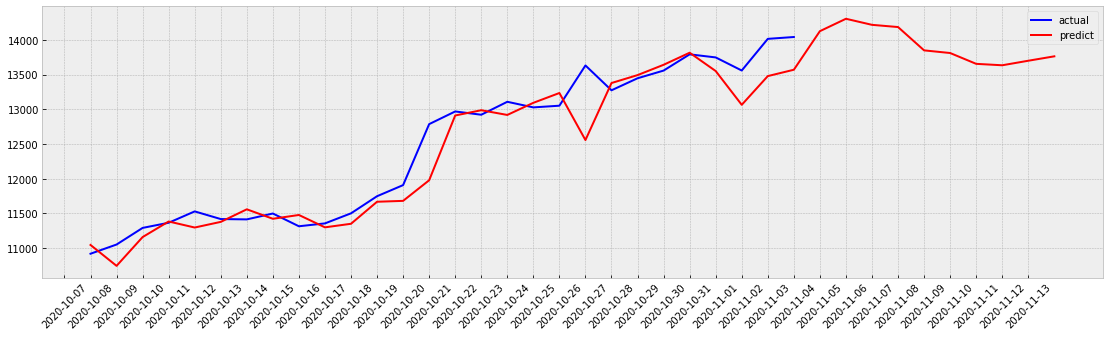

In [838]:
dates =[]
for i in range(len(verif_after_pred)):
  v =datetime.date(datetime(int(year), int(m), int(d))) + timedelta(days=i)
  dates.append(v.strftime('%Y-%m-%d'))
    
plt.figure(figsize=(5+verif_gap/2,5))
plt.plot(np.arange(0,verif_gap,1), real_verif_price[split_pt+len(test_pred)-verif_gap:], color ='blue',label = 'actual')
plt.plot(np.arange(0,len(real_verif_after_pred), 1), real_verif_after_pred, color='red', label='predict')
plt.xticks(np.arange(-1, len(dates)-1, 1), dates, rotation = 45) #한 칸 밀림
plt.legend()

In [832]:
#Golden Point & Dead Point
def GP_check(day):
  GP_can = day
  if holding == True:
    i = len(af)
  else:
    i = 1
  while i > 0:
    while day < len(af)-1:
      #print('day: %d' %day)
      today_profit = (af[day+1] - af[GP_can]) / af[GP_can] # 저점 기준 누적 손익률
      #print(today_profit)

      if today_profit < 0:
        GP_can = day + 1 #새로운 저점 = GP 후보
        day+=1
        break;

      elif (af[day+1] - af[day]) / af[day] >= 0.03: #한번에 3% 상승시
        Points.append(GP_can)
        day = DP_check(GP_can+1)
        GP_can = day
        break;

        
      elif today_profit >= 0.05: #고점 대비 5% 상승하면
        Points.append(GP_can) #GP on, 매매 순서대로 넣기 
        day = DP_check(GP_can+1)
        GP_can = day
        break;

      else:
        day+=1
        break;
    
    i-= 1

  return GP_can+1 # GP, DP 추가후 새로운 기준  

def DP_check(day):
  #다음날 부터 DP check
  DP_can = day
  if holding == True: #처음에 보유중이라면
    i = len(af) # 요청 범위만큼 반복
  else: # 아니라면 한번만.
    i = 1
  while i > 0:
    while day < len(af)-1:
      #print('day: %d' %day)
      today_profit = (af[day+1] - af[DP_can]) / af[DP_can] # 고점 기준 누적 손익률
      #print(today_profit)

      if today_profit > 0: #새로운 고점 = DP 후보
        DP_can = day+1
        day+=1
        break;

      elif (af[day+1] - af[day]) / af[day] <= -0.02: #한번에 2%하락하면
        Points.append(DP_can)
        day = GP_check(DP_can+1)
        DP_can = day
        break;

      elif today_profit <= -0.03: #고점 대비 3%하락하면
        Points.append(DP_can) # DP on
        day = GP_check(DP_can+1)
        DP_can = day
        break;

      else:
        day+=1
        break;
    
    i-=1

  return DP_can+1 # GP, DP 추가후 새로운 기준  


In [847]:
#최적 매매타이밍 알고리즘
#골든 포인트와 데드 포인트 찾기
#첫번째 GP: 0일 얼마 DP: 3일 얼마 수익률 5%
af = verif_after_pred #평가구간
#1번. 보유중인가요?
holding = True

#2. 매수 시작
today = 0
GPs = [] 
DPs = []
Points = [] #포인트들의 날짜를 저장할 예정
#print(af)

if holding: #매매 결정
  DP_check(0)

else: #4. 그럼 골든포인트 찾기
  GP_check(0)

#결과 출력
if len(Points) != 0:
  print('최적 매매 타이밍은 아래와 같습니다.\n')
  if holding == False:
    print('(미보유중)')
  else:
    print('(보유중)')

  for i in Points:
    v = datetime.date(datetime(int(year), int(m), int(d))) + timedelta(days=i)
    p = real_verif_after_pred.astype(int)[i]

    if holding == False: #먼저 사야할때
      print('buy: %s -' %v.strftime('%Y-%m-%d'), "{:,}$".format(p[0])) #p는 array형식이라 안됨
      holding = True
    else:
      print('sell: %s -' %v.strftime('%Y-%m-%d'), "{:,}$\n".format(p[0]))
      holding = False

else:
  print('매매를 보류합니다.\n')

print('신뢰도 - 종합 MCC: 63.33%, mape: 2.31%\n    최근 28일 MCC: 60.71%, mape: 1.72%')

최적 매매 타이밍은 아래와 같습니다.

(보유중)
sell: 2020-10-07 - 11,046$

buy: 2020-10-08 - 10,745$
sell: 2020-10-25 - 13,234$

buy: 2020-10-26 - 12,557$
sell: 2020-10-30 - 13,814$

buy: 2020-11-01 - 13,064$
sell: 2020-11-05 - 14,303$

신뢰도 - 종합 MCC: 63.33%, mape: 2.31%
    최근 28일 MCC: 60.71%, mape: 1.72%


In [834]:
#print("{:,}원".format(p[0]))
[2014-07-18 ~ 2020-09-02] 64win 7000ep
96 53 75 46
방향 정확도: 63.333%
MCC: 0.26
값 오차율: 2.31%

값 오차율: 1.72%
11 9 6 2
방향정확도: 60.714%
MCC: 0.27


In [835]:
# p = np.asarray(real_verif_price)
# for i in range(verif_gap):
#   t = split_pt+len(test_pred)-verif_gap
#   ac = verif_price[i+t] - verif_price[i+t-1]
#   pd = after_pred[i] - verif_price[i+t-1]
#   print('%.2f, %.2f' %(ac, pd))

In [836]:
#after_pred이 올바른 방향을 예측했는지에 대한 방향성 평가와 그 예측 값과 실제 값의 차이를 평가한 오차율를 제공합니다.
def CustomErrorRate(PRICE, TRAIN, TEST, VERIF):
  evalist = [TRAIN, TEST, VERIF]
  target_scores = []

  for target in range(len(evalist)): #평가항목 3개
    print(len(evalist[target]))

    if (target == 0):
      t = window_size -1 #시작위치
      iter = len(evalist[target]) #반복수
    elif (target == 1):
      t = split_pt -1
      iter = len((evalist[target]))
    else:
      t = split_pt + len(test_pred) -1
      iter = verif_gap
    
    scores = np.zeros((iter,1))
    for i in range(iter):
      per_predict_error = (PRICE[t+1] - evalist[target][i]) / PRICE[t+1]
      if (i == 0 ):
        scores[i] = np.abs(per_predict_error)
      else:
        if (PRICE[t+1] - PRICE[t] > 0): #가격오름 
          if (evalist[target][i] - evalist[target][i-1] > 0): #방향 맞췄을 때는
            scores[i]= np.square(per_predict_error) #패널티 줄여줌 소수니까 제곱으로 0.02 일때 1/50 효과
          else : #방향 틀렸을 때는
            scores[i]= np.abs(per_predict_error) #가중치 그대로

        elif (PRICE[t+1] - PRICE[t] < 0): #가격내림
          if (evalist[target][i] - evalist[target][i-1] < 0): #방향 맞췄을 때는
            scores[i]= np.square(per_predict_error)
          else: 
            scores[i]= np.abs(per_predict_error)

        else: #가격 같을때는
          scores[i]= np.abs(per_predict_error) #가중치 그대로    
  
        t+=1
    target_scores.append(scores)
  return target_scores

In [837]:
# #after 오차율은 변동됨 왜지? 모델 가져올때도 영향이있나?  예측 오차율: 1.077%
# print('실제값으로 평가') #실제값이 오차율 더 작게 나옴 15%정도
# error_rate = CustomErrorRate(real_verif_price, real_train_pred, real_test_pred, real_after_pred)
# print('학습 예측 오차율: %.3f%%' %(np.average(error_rate[0]*100))) #python에서 %%두개
# print('테스트 예측 오차율: %.3f%%' %(np.average(error_rate[1]*100)))
# print('미래 예측 오차율: %.3f%%' %(np.average(error_rate[2]*100)))